In [2]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scanpy as sc
import pickle

import sys
sys.path.append('./baseline/SpatialScope')
from utils import *

import warnings
warnings.filterwarnings('ignore')

if scRNA-seq dataset has cell type, we use the cell type

In [10]:
# scmap label
ad_sc = sc.read('../../datasets/sc/dataset9_seq_76.h5ad') 

df = pd.read_csv('dataset1_celltype.csv')
ad_sc.obs['subclass_label'] = np.array(df)

cell_type_column = 'subclass_label'
ad_sc.obs[cell_type_column] = ad_sc.obs[cell_type_column].astype(str)


cell_types = ['L5 IT',
 'Oligo',
 'L2/3 IT',
 'L6 CT',
 'Astro',
 'Pvalb',
 'L6 IT',
 'L5 ET',
 'L5/6 NP',
 'Sst',
 'Vip',
 'L6b',
 'Endo',
 'Lamp5',
 'VLMC',
 'Peri',
 'Sncg']+['OPC','Micro','PVM']
ad_sc = ad_sc[ad_sc.obs[cell_type_column].isin(cell_types)]

ad_sc = ad_sc[:,~np.array([_.startswith('MT-') for _ in ad_sc.var.index])]
ad_sc = ad_sc[:,~np.array([_.startswith('mt-') for _ in ad_sc.var.index])]


ad_sc.X.max(),ad_sc.shape

(ArrayView(207493., dtype=float32), (12333, 76))

if scRNA-seq dataset doesn't have cell type, we use the clustering result as cell type, just as the same as Tangram in the Spatial Benchmark.

In [5]:
# cluster label
ad_sc = sc.read('../../datasets/sc/dataset9_seq_76.h5ad') 


RNA_data_adata_label = ad_sc.copy()
sc.pp.normalize_total(RNA_data_adata_label)
sc.pp.log1p(RNA_data_adata_label)
sc.pp.highly_variable_genes(RNA_data_adata_label)
RNA_data_adata_label = RNA_data_adata_label[:, RNA_data_adata_label.var.highly_variable]
sc.pp.scale(RNA_data_adata_label, max_value=10)
sc.tl.pca(RNA_data_adata_label)
sc.pp.neighbors(RNA_data_adata_label)
sc.tl.leiden(RNA_data_adata_label, resolution=0.5)
ad_sc.obs['subclass_label'] = RNA_data_adata_label.obs.leiden

cell_type_column = 'subclass_label'
ad_sc.obs[cell_type_column] = ad_sc.obs[cell_type_column].astype(str)


ad_sc = ad_sc[:,~np.array([_.startswith('MT-') for _ in ad_sc.var.index])]
ad_sc = ad_sc[:,~np.array([_.startswith('mt-') for _ in ad_sc.var.index])]


ad_sc.X.max(),ad_sc.shape

(ArrayView(207493., dtype=float32), (14249, 76))

In [11]:
ad_sc.raw = ad_sc.copy()
sc.pp.normalize_total(ad_sc, inplace=True, target_sum=1e4)

sc.pp.highly_variable_genes(ad_sc, flavor='seurat_v3',n_top_genes=1000)

ad_sp = sc.read('../../datasets/sp/dataset9_spatial_76.h5ad')
merfish_genes = ad_sp.var.index.values.tolist() 

markers = ad_sc.var_names
len(set(markers))

76

In [12]:
ad_sc.var.loc[ad_sc.var.index.isin(markers),'Marker'] = True
ad_sc.var['Marker'] = ad_sc.var['Marker'].fillna(False)
ad_sc.var['highly_variable'] = ad_sc.var['Marker']

sc.pp.log1p(ad_sc)
sc.pp.pca(ad_sc,svd_solver='arpack', n_comps=30, use_highly_variable=True)

ad_sc.X.max()

9.20982

... storing 'subclass_label' as categorical


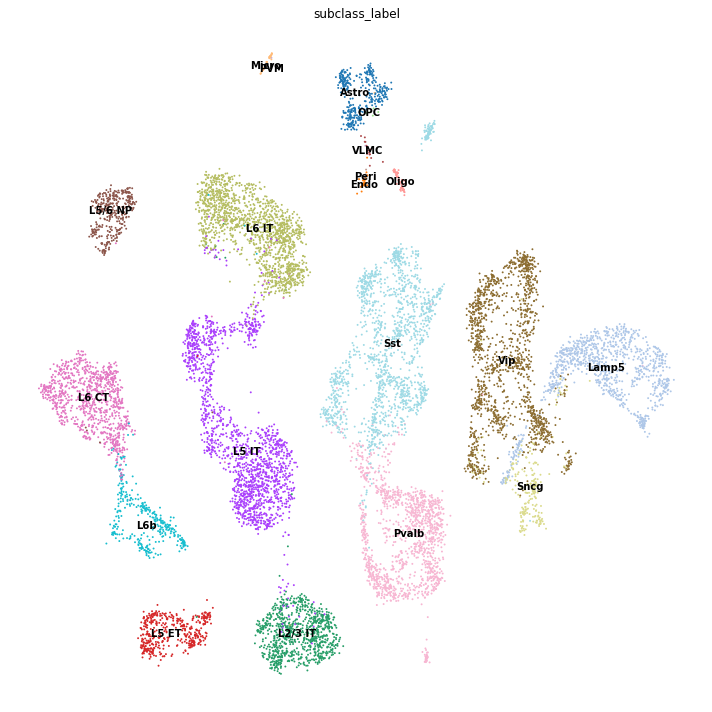

In [13]:
sc.pp.neighbors(ad_sc, metric='cosine', n_neighbors=30, n_pcs = 30)
sc.tl.umap(ad_sc, min_dist = 0.5, spread = 1, maxiter=60)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sc.pl.umap(
    ad_sc, color=cell_type_column, size=15, frameon=False, show=False, ax=axs,legend_loc='on data'
)
plt.tight_layout()

In [14]:
ad_sc.write('../../ckpt/sc/dataset9_seq_76_spscope.h5ad')